# Assignment 4: Surprises of (Deep) Learning
* **Student Name:** Abhijeet Sahdev
* **Date:** [Submission Date]
* **Assignment:** Programming Assignment 4

## Abstract
[Brief summary of findings and key discoveries]

## Introduction
Neural networks often surprise us with their behavior. This assignment explores fundamental surprises in deep learning through systematic experimentation with model initialization, agreement patterns, ensemble construction, and parallel training.

## Imports

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data.dataset import random_split
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from scipy import stats

import os
import time
import copy
import itertools
from collections import defaultdict
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("colorblind")
plt.rcParams.update({'font.size': 12, 'figure.figsize': (10, 6)})

## Set device and seed for reproducibility

In [2]:
def set_random_seeds(seed=42):
    """Set all random seeds for reproducibility"""
    torch.manual_seed(seed)
    np.random.seed(seed)
    if torch.backends.mps.is_available():
        torch.mps.manual_seed(seed)
        device = torch.device("mps")
    elif torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        device = torch.device("cuda")
    else:
        device = torch.device("cpu")
    return device

device = set_random_seeds(33)

## Load CIFAR-10 

With corresponding dataloaders from train, val and test splits.

In [3]:
def getCIFAR10Loaders(batchSize=128, numWorkers=2):
    """CIFAR-10 data loaders with standard processing"""
    transform_train = transforms.Compose([
        transforms.RandomCrop(32,padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
    ])

    transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
    ])

    trainDataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
    testDataset = torchvision.datasets.CIFAR10(root='./data',train=False,download=True,transform=transform_test)

    trainData, valData = random_split(trainDataset, [40000,10000]) # 80%, 20% respectively

    trainLoader = DataLoader(trainData, batch_size=batchSize, num_workers=numWorkers)
    valLoader = DataLoader(valData, batch_size=batchSize, num_workers=numWorkers)
    testLoader = DataLoader(testDataset, batch_size=batchSize, num_workers=numWorkers)

    return trainLoader, valLoader, testLoader

set_random_seeds(33)
trainLoader, valLoader, testLoader = getCIFAR10Loaders(numWorkers=0)
print("Data loading complete")

Data loading complete


## CNN Architecture

In [4]:
class SmallCNNWithDrop(nn.Module):
    """
    Small CNN for CIFAR-10 with dropout regularization.
    
    Architecture Requirements:
    - 3 convolutional layers (suggest: 3→32→64→64 channels)
    - ReLU activations and pooling layers
    - 2 fully connected layers with dropout (rate=0.3)
    - Target: ~1-2MB GPU memory per model
    """
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.conv1 = nn.Conv2d(3, 32, (3,3), padding=1)
        self.conv2 = nn.Conv2d(32, 64, (5,5), padding=2)
        self.conv3 = nn.Conv2d(64, 64, (3,3), padding=1)
        self.relu = nn.ReLU()
        self.avgPool = nn.AvgPool2d(kernel_size=(5,5), padding=2)
        self.fc1 = nn.LazyLinear(192)
        self.dropout = nn.Dropout(p=0.3)
        self.fc2 = nn.LazyLinear(10) # number of classes in CIFAR10

    def forward(self,x):
        x1 = self.avgPool(self.relu(self.conv1(x)))
        x2 = self.avgPool(self.relu(self.conv2(x1)))
        x3 = self.avgPool(self.relu(self.conv3(x2)))
        flattenedX = torch.flatten(x3,1)
        x4 = self.relu(self.fc1(flattenedX))
        x5 = self.dropout(x4)
        return self.fc2(x5)
    

print("=== Testing CNN Architecture ===")
model = SmallCNNWithDrop()
test_input = torch.randn(1, 3, 32, 32)
output = model(test_input)
print(f"Model output shape: {output.shape}")
print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")

=== Testing CNN Architecture ===
Model output shape: torch.Size([1, 10])
Model parameters: 103,498


## Multi-Model Training System

In [ ]:
class MultiModelTrainer:
    """
    Train multiple models with different random initializations.
    
    Experimental Design:
    - 10 identical CNN models with different initialization seeds
    - Each model trained for 50 epochs
    - Adaptive learning rate: start at 0.01, reduce by 0.5 when stagnation
    - Select best model based on validation loss for each training run
    """
    def __init__(self, model_fn, base_seed=33, num_models=10):
        # TODO: Initialize multiple models with different seeds
        # TODO: Set up optimizers and learning rate schedulers
        # Use seeds: base_seed, base_seed+1, ..., base_seed+num_models-1
        self.base_seed = base_seed
        self.num_models = num_models
        self.models = []
        self.optimizers = []
        self.schedulers = []
        
        # TODO: Create models with different initialization seeds
        for i in range(num_models):
            torch.manual_seed(base_seed+i)
            model = model_fn().to(device)
            optimizer = optim.Adam(model.parameters(), lr=0.01)
            reduceLRonPlat = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)
            self.models.append(model)
            self.optimizers.append(optimizer)
            self.schedulers.append(reduceLRonPlat)
        
    def train_single_model(self, model_idx, train_loader, val_loader, num_epochs=50):
        """Train a single model and return training history"""
        # TODO: Implement training loop with early stopping
        # TODO: Use ReduceLROnPlateau scheduler
        # TODO: Track training/validation loss and accuracy
        
        model = self.models[model_idx]
        optimizer = self.optimizers[model_idx]
        scheduler = self.schedulers[model_idx]
        criterion = nn.CrossEntropyLoss()
        trainLosses = []
        valLosses = []
        trainAccs = []
        valAccs = []
        earlyStopLimit = 5
        bestValLoss = float('inf')
        bestValAcc = 0.0
        epochsWithNoImprovement = 0
        bestWeights = copy.deepcopy(model.state_dict())

        for i in range(num_epochs):
            
            trainLoss = 0.0
            trainSamples = 0
            valLoss = 0.0
            valSamples = 0
            correctTrain = 0
            correctVal = 0
            
            for xb, yb in train_loader:
                xb = xb.to(device)
                yb = yb.to(device)
                
                model.train()
                logits = model(xb)
                loss = criterion(logits,yb)
                loss.backward()
                optimizer.step()
                optimizer.zero_grad()

                pred = logits.argmax(dim=1)
                correctPreds = (pred==yb).sum().item()
                correctTrain += correctPreds

                batchSize = xb.size(0)
                trainSamples += batchSize
                
                batchTrainLoss = loss.item() * batchSize
                trainLoss += batchTrainLoss
                

            avgTrainLoss = trainLoss / trainSamples

            trainLosses.append(avgTrainLoss)
            trainAccs.append(correctTrain/trainSamples)

            for xb, yb in val_loader:
                xb = xb.to(device)
                yb = yb.to(device)
                
                model.eval()
                logits = model(xb)
                loss = criterion(logits,yb)
                
                preds = logits.argmax(dim=1)
                correctPreds = (yb == preds).sum().item()
                correctVal += correctPreds

                batchSize = xb.size(0)
                valSamples += batchSize
                
                batchValLoss = loss.item() * batchSize
                valLoss += batchValLoss

            
            avgValLoss = valLoss / valSamples
            avgValAcc = correctVal / valSamples

            valLosses.append(avgValLoss)
            valAccs.append(avgValAcc)

            scheduler.step(avgValLoss)

            print(f"Epoch {i+1}/{num_epochs}, Train Loss: {avgTrainLoss:.6f}, Val Loss: {avgValLoss:.6f}")

            if avgValLoss < bestValLoss:
                bestValLoss = avgValLoss
                epochsWithNoImprovement = 0
                bestEpoch = i
                bestWeights = copy.deepcopy(model.state_dict())
            
            if avgValAcc > bestValAcc:
                bestValAcc = avgValAcc

            else:
                epochsWithNoImprovement += 1
                if epochsWithNoImprovement >= earlyStopLimit:
                    break
            
        return {
            'trainAcc' : trainAccs,
            'trainLoss' : trainLosses,
            'valAcc' : valAccs, 
            'valLoss' : valLosses, 
            'bestValAcc' : bestValAcc, 
            'bestEpoch' : bestEpoch,
            'bestWeights' : bestWeights
        }  
    

    def train_all_models(self, train_loader, val_loader, num_epochs=50):
        """
        Train all models and collect statistics.
        
        Returns:
            results: Dictionary containing:
                - train_accuracies: (num_models, num_epochs)
                - val_accuracies: (num_models, num_epochs)
                - train_losses: (num_models, num_epochs)
                - val_losses: (num_models, num_epochs)
                - best_epoch_per_model: (num_models,)
                - final_performance: (num_models,)
        """
        # TODO: Train each model sequentially
        # TODO: Collect comprehensive statistics
        # TODO: Return structured results

        allTrainAccuracies = []
        allTrainLosses = []
        allValAccuracies = []
        allValLosses = []
        bestValAccs = []
        bestEpochs = []
        bestWeights = []

        for i in range(self.num_models):
            print("------------------------------------------------")
            print(f"Training model {i+1}/{self.num_models}")
            print("------------------------------------------------")
            print("------------------------------------------------")
            statistics = self.train_single_model(i,train_loader,val_loader,num_epochs)
            allTrainAccuracies.append(statistics['trainAcc'])
            allTrainLosses.append(statistics['trainLoss'])
            allValAccuracies.append(statistics['valAcc'])
            allValLosses.append(statistics['valLoss'])
            bestEpochs.append(statistics['bestEpoch'])
            bestValAccs.append(statistics['bestValAcc'])
            bestWeights.append(statistics['bestWeights'])
        return {
            'train_accuracies' : allTrainAccuracies,
            'val_accuracies' : allValAccuracies,
            'train_losses' : allTrainLosses,
            'val_losses' : allValLosses,
            'best_epoch_per_model' : bestEpochs,
            'final_performance': bestValAccs,
            'bestWeights' : bestWeights
        }


trainer = MultiModelTrainer(
    lambda: SmallCNNWithDrop(),
    base_seed=33,
    num_models=10
)
print("Multi-model trainer initialized")


Multi-model trainer initialized


In [6]:
results = trainer.train_all_models(trainLoader,valLoader)
print("Training complete!")

------------------------------------------------
Training model 1/10
------------------------------------------------
------------------------------------------------
Epoch 1/50, Train Loss: 1.866962, Val Loss: 1.699037
Epoch 2/50, Train Loss: 1.598888, Val Loss: 1.550705
Epoch 3/50, Train Loss: 1.490523, Val Loss: 1.426326
Epoch 4/50, Train Loss: 1.408852, Val Loss: 1.315383
Epoch 5/50, Train Loss: 1.348627, Val Loss: 1.263817
Epoch 6/50, Train Loss: 1.296007, Val Loss: 1.231639
Epoch 7/50, Train Loss: 1.252173, Val Loss: 1.199953
Epoch 8/50, Train Loss: 1.221245, Val Loss: 1.165263
Epoch 9/50, Train Loss: 1.178438, Val Loss: 1.108336
Epoch 10/50, Train Loss: 1.139203, Val Loss: 1.100048
Epoch 11/50, Train Loss: 1.112204, Val Loss: 1.080346
Epoch 12/50, Train Loss: 1.085257, Val Loss: 1.038378
Epoch 13/50, Train Loss: 1.073271, Val Loss: 1.067146
Epoch 14/50, Train Loss: 1.047881, Val Loss: 1.012516
Epoch 15/50, Train Loss: 1.027556, Val Loss: 1.014922
Epoch 16/50, Train Loss: 1.00170

## Statistical Analysis Functions

In [14]:
def pad_to_max_length(list_of_lists, fill_value=np.nan):
    maxlen = max(len(lst) for lst in list_of_lists)
    return np.array([lst + [fill_value]*(maxlen - len(lst)) for lst in list_of_lists])

def analyze_initialization_variance(results):
    """
    Compute statistical measures across the 10 model runs.
    For each epoch, calculate:
    - Mean performance across all models
    - Standard deviation across models
    - Minimum and maximum performance
    - 95% confidence intervals
    Returns a dictionary with statistics for each epoch.
    """
    # Extract validation accuracies: shape (num_models, num_epochs)
    val_accuracies = pad_to_max_length(results['val_accuracies'])
    num_epochs = val_accuracies.shape[1]
    iniVariance = {
        'mean': [],
        'std': [],
        'min': [],
        'max': [],
        'ci95_low': [],
        'ci95_high': []
    }
    for epoch in range(num_epochs):
        vals = val_accuracies[:, epoch]
        mean = np.mean(vals)
        std = np.std(vals, ddof=1)
        min_val = np.min(vals)
        max_val = np.max(vals)
        ci95 = stats.t.interval(0.95, len(vals)-1, loc=mean, scale=std/np.sqrt(len(vals))) if len(vals) > 1 else (mean, mean)
        iniVariance['mean'].append(mean)
        iniVariance['std'].append(std)
        iniVariance['min'].append(min_val)
        iniVariance['max'].append(max_val)
        iniVariance['ci95_low'].append(ci95[0])
        iniVariance['ci95_high'].append(ci95[1])
    return iniVariance

# Then, when computing statistics, use np.nanmean, np.nanstd, etc.
def plot_initialization_variance(results):
    """
    Generate professional visualization showing:
    - Average performance with confidence bars
    - Min/max envelope
    - Individual model trajectories (optional)
    """
    iniVariance = analyze_initialization_variance(results)
    epochs = np.arange(1, len(iniVariance['mean']) + 1)
    val_accuracies = pad_to_max_length(results['val_accuracies'])
    train_accuracies = pad_to_max_length(results['train_accuracies'])
    train_losses = pad_to_max_length(results['train_losses'])
    final_performance = np.array(results['final_performance'])
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    # Plot 1 - Training accuracy over time
    ax = axes[0, 0]
    mean_train = np.mean(train_accuracies, axis=0)
    std_train = np.std(train_accuracies, axis=0, ddof=1)
    ax.plot(epochs, mean_train, label='Mean Train Acc', color='C0')
    ax.fill_between(epochs, mean_train - std_train, mean_train + std_train, color='C0', alpha=0.2, label='Std Dev')
    for i in range(train_accuracies.shape[0]):
        ax.plot(epochs, train_accuracies[i], color='C0', alpha=0.15, linewidth=0.8)
    ax.set_title('Training Accuracy Over Time')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Accuracy')
    ax.legend()
    # Plot 2 - Validation accuracy over time
    ax = axes[0, 1]
    ax.plot(epochs, iniVariance['mean'], label='Mean Val Acc', color='C1')
    ax.fill_between(epochs, iniVariance['ci95_low'], iniVariance['ci95_high'], color='C1', alpha=0.2, label='95% CI')
    ax.fill_between(epochs, iniVariance['min'], iniVariance['max'], color='C1', alpha=0.1, label='Min/Max Envelope')
    for i in range(val_accuracies.shape[0]):
        ax.plot(epochs, val_accuracies[i], color='C1', alpha=0.15, linewidth=0.8)
    ax.set_title('Validation Accuracy Over Time')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Accuracy')
    ax.legend()
    # Plot 3 - Training loss over time
    ax = axes[1, 0]
    mean_train_loss = np.mean(train_losses, axis=0)
    std_train_loss = np.std(train_losses, axis=0, ddof=1)
    ax.plot(epochs, mean_train_loss, label='Mean Train Loss', color='C2')
    ax.fill_between(epochs, mean_train_loss - std_train_loss, mean_train_loss + std_train_loss, color='C2', alpha=0.2, label='Std Dev')
    for i in range(train_losses.shape[0]):
        ax.plot(epochs, train_losses[i], color='C2', alpha=0.15, linewidth=0.8)
    ax.set_title('Training Loss Over Time')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    ax.legend()
    # Plot 4 - Final performance distribution
    ax = axes[1, 1]
    ax.hist(final_performance, bins=10, color='C3', alpha=0.7, edgecolor='black')
    ax.set_title('Final Validation Loss Distribution (Best per Model)')
    ax.set_xlabel('Best Validation Loss')
    ax.set_ylabel('Number of Models')
    plt.tight_layout()
    plt.show()


def generate_variance_statistics(results):
    """
    Generate a single DataFrame with statistics for all tracked metrics across epochs and final performance.
    The DataFrame contains a 'Metric' column to distinguish between:
      - train_accuracies
      - val_accuracies
      - train_losses
      - val_losses
      - best_epoch_per_model (summary row)
      - final_performance (summary row)
    Columns: [Metric, Epoch, Mean, Std, Min, Max, 95% CI Low, 95% CI High]
    """
    def compute_stats(arr, metric_name):
        arr = np.array(arr)
        num_epochs = arr.shape[1]
        stats_rows = []
        for epoch in range(num_epochs):
            vals = arr[:, epoch]
            mean = np.mean(vals)
            std = np.std(vals, ddof=1)
            min_val = np.min(vals)
            max_val = np.max(vals)
            ci95 = stats.t.interval(0.95, len(vals)-1, loc=mean, scale=std/np.sqrt(len(vals))) if len(vals) > 1 else (mean, mean)
            stats_rows.append({
                'Metric': metric_name,
                'Epoch': epoch+1,
                'Mean': mean,
                'Std': std,
                'Min': min_val,
                'Max': max_val,
                '95% CI Low': ci95[0],
                '95% CI High': ci95[1]
            })
        return stats_rows

    all_rows = []
    all_rows += compute_stats(pad_to_max_length(results['train_accuracies']), 'train_accuracies')
    all_rows += compute_stats(pad_to_max_length(results['val_accuracies']), 'val_accuracies')
    all_rows += compute_stats(pad_to_max_length(results['train_losses']), 'train_losses')
    all_rows += compute_stats(pad_to_max_length(results['val_losses']), 'val_losses')

    # Final performance (best validation loss per model)
    final_perf = np.array(results['final_performance'])
    mean = np.mean(final_perf)
    std = np.std(final_perf, ddof=1)
    min_val = np.min(final_perf)
    max_val = np.max(final_perf)
    ci95 = stats.t.interval(0.95, len(final_perf)-1, loc=mean, scale=std/np.sqrt(len(final_perf))) if len(final_perf) > 1 else (mean, mean)
    all_rows.append({
        'Metric': 'final_performance',
        'Epoch': None,
        'Mean': mean,
        'Std': std,
        'Min': min_val,
        'Max': max_val,
        '95% CI Low': ci95[0],
        '95% CI High': ci95[1]
    })

    # Best epoch per model
    best_epochs = np.array(results['best_epoch_per_model'])
    mean = np.mean(best_epochs)
    std = np.std(best_epochs, ddof=1)
    min_val = np.min(best_epochs)
    max_val = np.max(best_epochs)
    ci95 = stats.t.interval(0.95, len(best_epochs)-1, loc=mean, scale=std/np.sqrt(len(best_epochs))) if len(best_epochs) > 1 else (mean, mean)
    all_rows.append({
        'Metric': 'best_epoch_per_model',
        'Epoch': None,
        'Mean': mean,
        'Std': std,
        'Min': min_val,
        'Max': max_val,
        '95% CI Low': ci95[0],
        '95% CI High': ci95[1]
    })

    return all_rows


print("Statistical analysis functions defined.")

Statistical analysis functions defined.


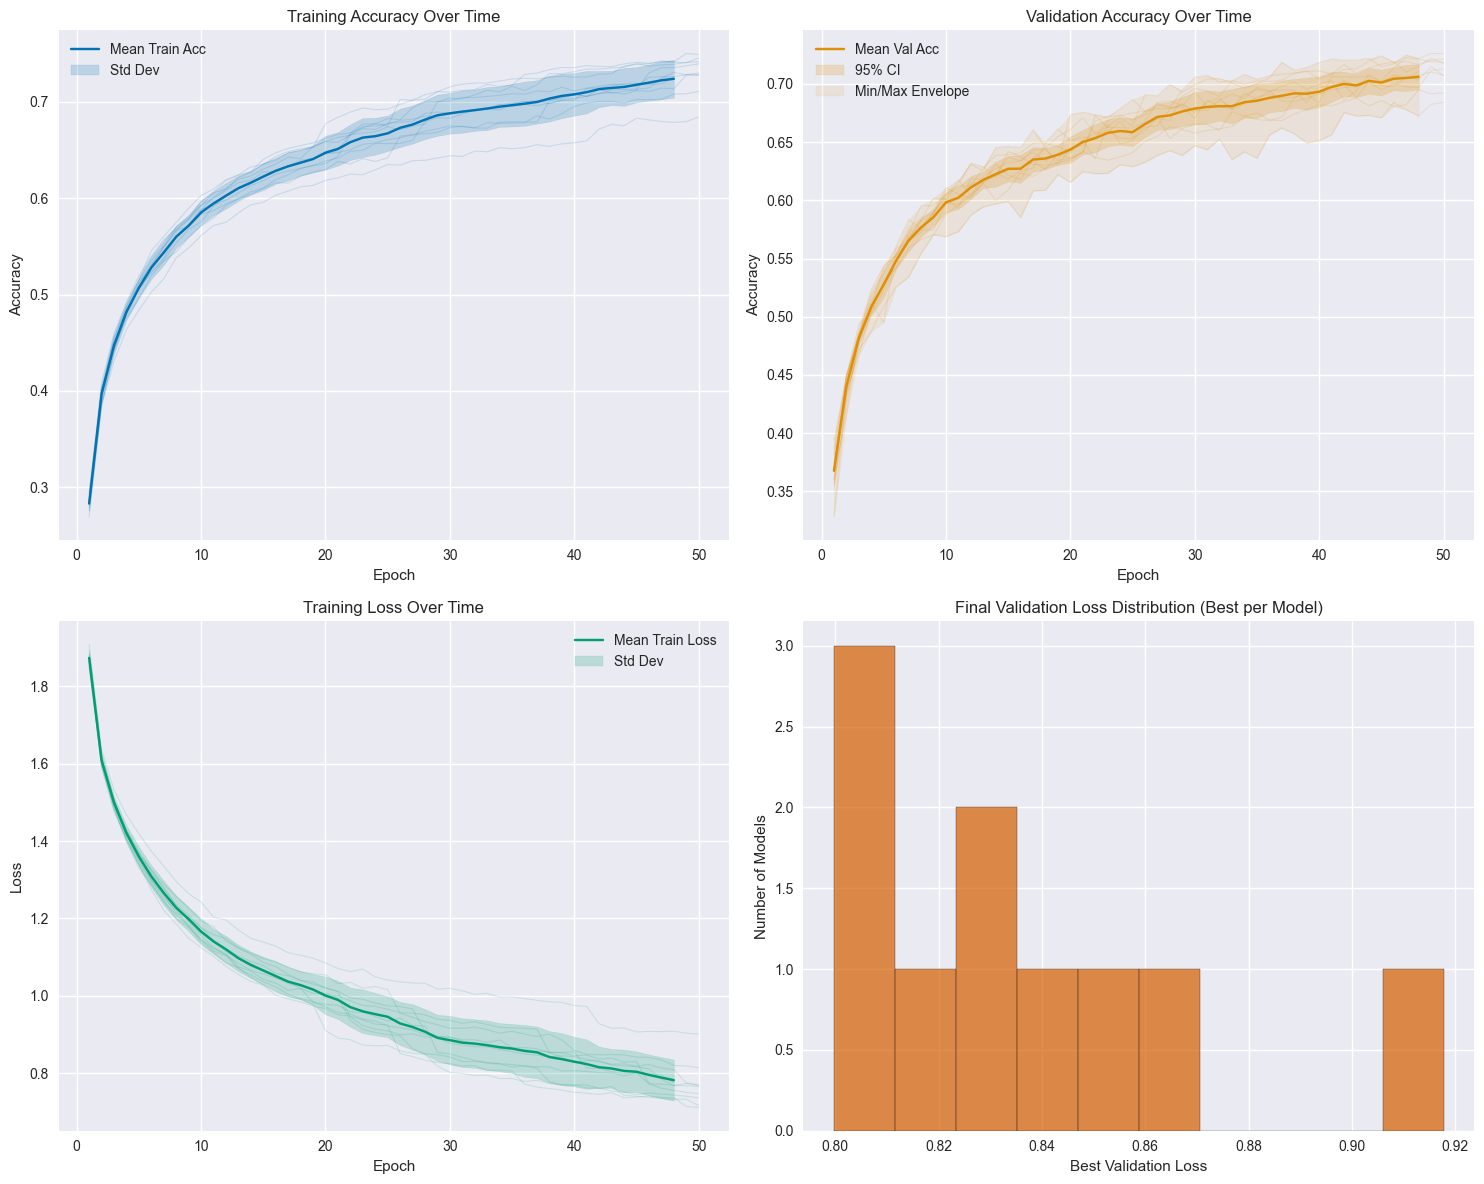

In [15]:
plot_initialization_variance(results)

In [16]:
analyze_initialization_variance(results)

{'mean': [0.36765,
  0.44000000000000006,
  0.48148,
  0.50857,
  0.5275999999999998,
  0.5482899999999999,
  0.56546,
  0.5766199999999999,
  0.58543,
  0.5981799999999999,
  0.6022399999999999,
  0.61096,
  0.61747,
  0.62241,
  0.62705,
  0.6271300000000001,
  0.6349800000000001,
  0.6358900000000001,
  0.63914,
  0.6435299999999999,
  0.64997,
  0.6533500000000001,
  0.65785,
  0.65952,
  0.6584800000000001,
  0.6654899999999999,
  0.6716200000000001,
  0.6729200000000001,
  0.6763200000000001,
  0.67877,
  0.68017,
  0.6808299999999999,
  0.68082,
  0.68423,
  0.6854699999999998,
  0.68794,
  0.68975,
  0.6918300000000001,
  0.6914899999999999,
  0.6931900000000001,
  0.69731,
  0.69996,
  0.69865,
  0.7026,
  0.70107,
  0.7044,
  0.70502,
  0.7060399999999999,
  nan,
  nan],
 'std': [0.018371248672253534,
  0.012321435702781458,
  0.007683141718507251,
  0.010069320842153263,
  0.015545846176176246,
  0.010013152461748597,
  0.013001470002358278,
  0.011157140215027225,
  0.01050

In [17]:
generate_variance_statistics(results)

[{'Metric': 'train_accuracies',
  'Epoch': 1,
  'Mean': 0.2831725,
  'Std': 0.007565505142127359,
  'Min': 0.269575,
  'Max': 0.294625,
  '95% CI Low': 0.2777604636492889,
  '95% CI High': 0.2885845363507111},
 {'Metric': 'train_accuracies',
  'Epoch': 2,
  'Mean': 0.3967275,
  'Std': 0.008477924356166965,
  'Min': 0.3838,
  'Max': 0.40835,
  '95% CI Low': 0.3906627582633692,
  '95% CI High': 0.4027922417366308},
 {'Metric': 'train_accuracies',
  'Epoch': 3,
  'Mean': 0.44749249999999996,
  'Std': 0.008873071386692053,
  'Min': 0.43095,
  'Max': 0.459825,
  '95% CI Low': 0.44114508710620226,
  '95% CI High': 0.45383991289379766},
 {'Metric': 'train_accuracies',
  'Epoch': 4,
  'Mean': 0.482205,
  'Std': 0.008375682393426558,
  'Min': 0.46385,
  'Max': 0.4922,
  '95% CI Low': 0.4762133977574974,
  '95% CI High': 0.4881966022425026},
 {'Metric': 'train_accuracies',
  'Epoch': 5,
  'Mean': 0.5071100000000001,
  'Std': 0.010398946260719568,
  'Min': 0.483925,
  'Max': 0.519425,
  '95% CI L

## Model Agreement Analyzer

In [37]:
class ModelAgreementAnalyzer:
    """
    Analyze agreement patterns between trained models.
    
    Key Metrics:
    - Agreement Rate: % of samples where both models predict correctly
    - Disagreement Patterns: Where do models disagree?
    - Coverage Rate: % of samples where at least one model is correct
    """
    
    def __init__(self, models, model_names=None):
        """Initialize with trained models for comparison"""
        self.models = models
        self.model_names = model_names or [f"Model_{i}" for i in range(len(models))]
        self.device = next(models[0].parameters()).device
        
    def analyze_pairwise_agreement(self, data_loader, model_idx_a=0, model_idx_b=1):
        """
        Analyze agreement between two specific models.
        
        Returns:
            agreement_stats: Dictionary with comprehensive agreement metrics
        """
        # TODO: Get predictions from both models
        # TODO: Calculate all agreement statistics
        # TODO: Return comprehensive analysis
        model_a = self.models[model_idx_a].to(self.device)
        model_b = self.models[model_idx_b].to(self.device)
        model_a.eval()
        model_b.eval()
        all_preds_a = []
        all_preds_b = []
        all_labels = []
        with torch.no_grad():
            for xb, yb in data_loader:
                xb = xb.to(self.device)
                yb = yb.to(self.device)
                
                logits_a = model_a(xb)
                logits_b = model_b(xb)
               
                preds_a = logits_a.argmax(dim=1)
                preds_b = logits_b.argmax(dim=1)

                all_preds_a.append(preds_a)
                all_preds_b.append(preds_b)
                all_labels.append(yb)

        # to compare at once, using torch.cat                
        preds_a = torch.cat(all_preds_a)
        preds_b = torch.cat(all_preds_b)
        labels = torch.cat(all_labels)

        #comparisions
        correct_a = preds_a == labels
        correct_b = preds_b == labels

        #agreement stats
        both_correct = correct_a & correct_b
        both_incorrect = (~correct_a) & (~correct_b)
        only_a_correct = correct_a & (~correct_b)
        only_b_correct = (~correct_a) & correct_b
        at_least_one_correct = correct_a | correct_b
        agreement_rate = (preds_a == preds_b).float().mean().item()
        coverage_rate = at_least_one_correct.float().mean().item()
        agreement_stats = {
            'both_correct': both_correct.float().mean().item(),
            'both_incorrect': both_incorrect.float().mean().item(),
            'only_a_correct': only_a_correct.float().mean().item(),
            'only_b_correct': only_b_correct.float().mean().item(),
            'coverage_rate': coverage_rate,
            'individual_accuracy_a': correct_a.float().mean().item(),
            'individual_accuracy_b': correct_b.float().mean().item(),
            'agreement_rate': agreement_rate
        }
        
        return agreement_stats
        
    
    def find_disagreement_examples(self, data_loader, model_idx_a=0, model_idx_b=1, num_examples=10):
        """Find specific examples where models disagree"""
        # TODO: Collect disagreement examples with images
        # TODO: Return examples with true labels and predictions
        model_a = self.models[model_idx_a].to(self.device)
        model_b = self.models[model_idx_b].to(self.device)
        model_a.eval()
        model_b.eval()
        images = []
        labels = []
        preds_a = []
        preds_b = []
        with torch.no_grad():
            for xb, yb in data_loader:
                xb = xb.to(self.device)
                yb = yb.to(self.device)
                logits_a = model_a(xb)
                logits_b = model_b(xb)
                pa = logits_a.argmax(dim=1)
                pb = logits_b.argmax(dim=1)
                for i in range(xb.size(0)):
                    if pa[i] != pb[i]:
                        images.append(xb[i])
                        labels.append(yb[i].item())
                        preds_a.append(pa[i].item())
                        preds_b.append(pb[i].item())
                    if len(images) >= num_examples:
                        break
                if len(images) >= num_examples:
                    break
        return {
            'images': images,
            'labels': labels,
            'preds_a': preds_a,
            'preds_b': preds_b
        }
    
    def analyze_all_pairs(self, data_loader):
        """Analyze agreement patterns across all model pairs"""
        # TODO: Systematic analysis across all 45 pairs of 10 models
        # TODO: Create comprehensive agreement matrix
        n = len(self.models)
        agreement_matrix = np.zeros((n, n))
        accuracies = []
        for i in range(n):
            for j in range(i, n):
                stats = self.analyze_pairwise_agreement(data_loader, i, j)
                agreement_matrix[i, j] = stats['agreement_rate']
                agreement_matrix[j, i] = stats['agreement_rate']
                accuracies.append(stats['individual_accuracy_a'])
        return agreement_matrix, np.unique(accuracies)


print("Model agreement analyzer defined")
models = trainer.models
agreementAnalyzer = ModelAgreementAnalyzer(models)
agreementMatrix, accuracies = agreementAnalyzer.analyze_all_pairs(testLoader)
print(" Agreement Matrix \n ",agreementMatrix)
print(" Accuracies are \n ",accuracies)


Model agreement analyzer defined
 Agreement Matrix 
  [[1.         0.77700001 0.77399999 0.75929999 0.77679998 0.75379997
  0.77380002 0.75080001 0.76590002 0.75950003]
 [0.77700001 1.         0.77340001 0.77270001 0.77090001 0.76620001
  0.7658     0.74330002 0.77079999 0.759     ]
 [0.77399999 0.77340001 1.         0.76770002 0.76740003 0.75639999
  0.76709998 0.74720001 0.76480001 0.7586    ]
 [0.75929999 0.77270001 0.76770002 1.         0.76279998 0.75010002
  0.76289999 0.74269998 0.764      0.75559998]
 [0.77679998 0.77090001 0.76740003 0.76279998 1.         0.7536
  0.76990002 0.74900001 0.76670003 0.76550001]
 [0.75379997 0.76620001 0.75639999 0.75010002 0.7536     1.
  0.75139999 0.73390001 0.75709999 0.73409998]
 [0.77380002 0.7658     0.76709998 0.76289999 0.76990002 0.75139999
  1.         0.74839997 0.75669998 0.7554    ]
 [0.75080001 0.74330002 0.74720001 0.74269998 0.74900001 0.73390001
  0.74839997 1.         0.73989999 0.73589998]
 [0.76590002 0.77079999 0.76480001 0.7

### Bonus 1

In [38]:
def get_off_diagonal_max_min(matrix):
    n = matrix.shape[0]
    mask = ~np.eye(n, dtype=bool)
    off_diag_values = matrix[mask]
    max_val = np.max(off_diag_values)
    min_val = np.min(off_diag_values)
    max_idx = np.argwhere((matrix == max_val) & mask)[0] #first occurrence
    min_idx = np.argwhere((matrix == min_val) & mask)[0]
    return max_val, tuple(max_idx), min_val, tuple(min_idx)

max_val, max_pos, min_val, min_pos = get_off_diagonal_max_min(agreementMatrix)
print(f"Max agreement is : {max_val:.4f} between model_{max_pos[0]} and model_{max_pos[1]}")
print(f"Min agreement is : {min_val:.4f} between model_{min_pos[0]} and model_{min_pos[1]}")
mean_agreement = np.mean(agreementMatrix)
std_agreement = np.std(agreementMatrix)
print(f"Mean agreement: {mean_agreement:.4f}")
print(f"Std of agreement: {std_agreement:.4f}")

Max agreement is : 0.7770 between model_0 and model_1
Min agreement is : 0.7339 between model_5 and model_7
Mean agreement: 0.7828
Std of agreement: 0.0732


In [20]:
agreementAnalyzer.find_disagreement_examples(testLoader) # between model_0 and model_1

{'images': [tensor([[[ 0.5756,  0.8082,  0.9827,  ...,  1.4673,  1.4867,  1.2928],
           [ 0.5368,  0.7307,  0.8858,  ...,  1.4867,  1.5061,  1.2347],
           [ 0.5756,  0.6725,  0.8276,  ...,  1.5642,  1.5255,  1.2347],
           ...,
           [-0.7038, -1.3241, -1.2466,  ..., -0.7038, -1.2854, -1.1303],
           [-0.7038, -1.2660, -1.2078,  ..., -1.3241, -1.2466, -0.9752],
           [-0.6457, -1.2660, -1.2466,  ..., -1.2660, -1.1884, -1.0140]],
  
          [[ 0.6498,  1.0431,  1.1021,  ...,  1.4364,  1.5544,  1.1808],
           [ 0.6301,  1.1021,  1.2004,  ...,  1.6724,  1.8101,  1.3184],
           [ 0.6104,  1.0824,  1.2201,  ...,  1.6724,  1.8101,  1.3381],
           ...,
           [-0.8646, -1.3759, -1.2186,  ..., -0.0779, -0.8646, -0.9629],
           [-0.8056, -1.2776, -1.1202,  ..., -1.1202, -1.1596, -1.0612],
           [-0.8842, -1.3956, -1.2776,  ..., -1.1792, -1.1399, -1.0809]],
  
          [[ 0.6856,  1.4270,  1.5441,  ...,  1.8563,  1.9148,  1.1149],
 

## Multi-Model Agreement Evolution

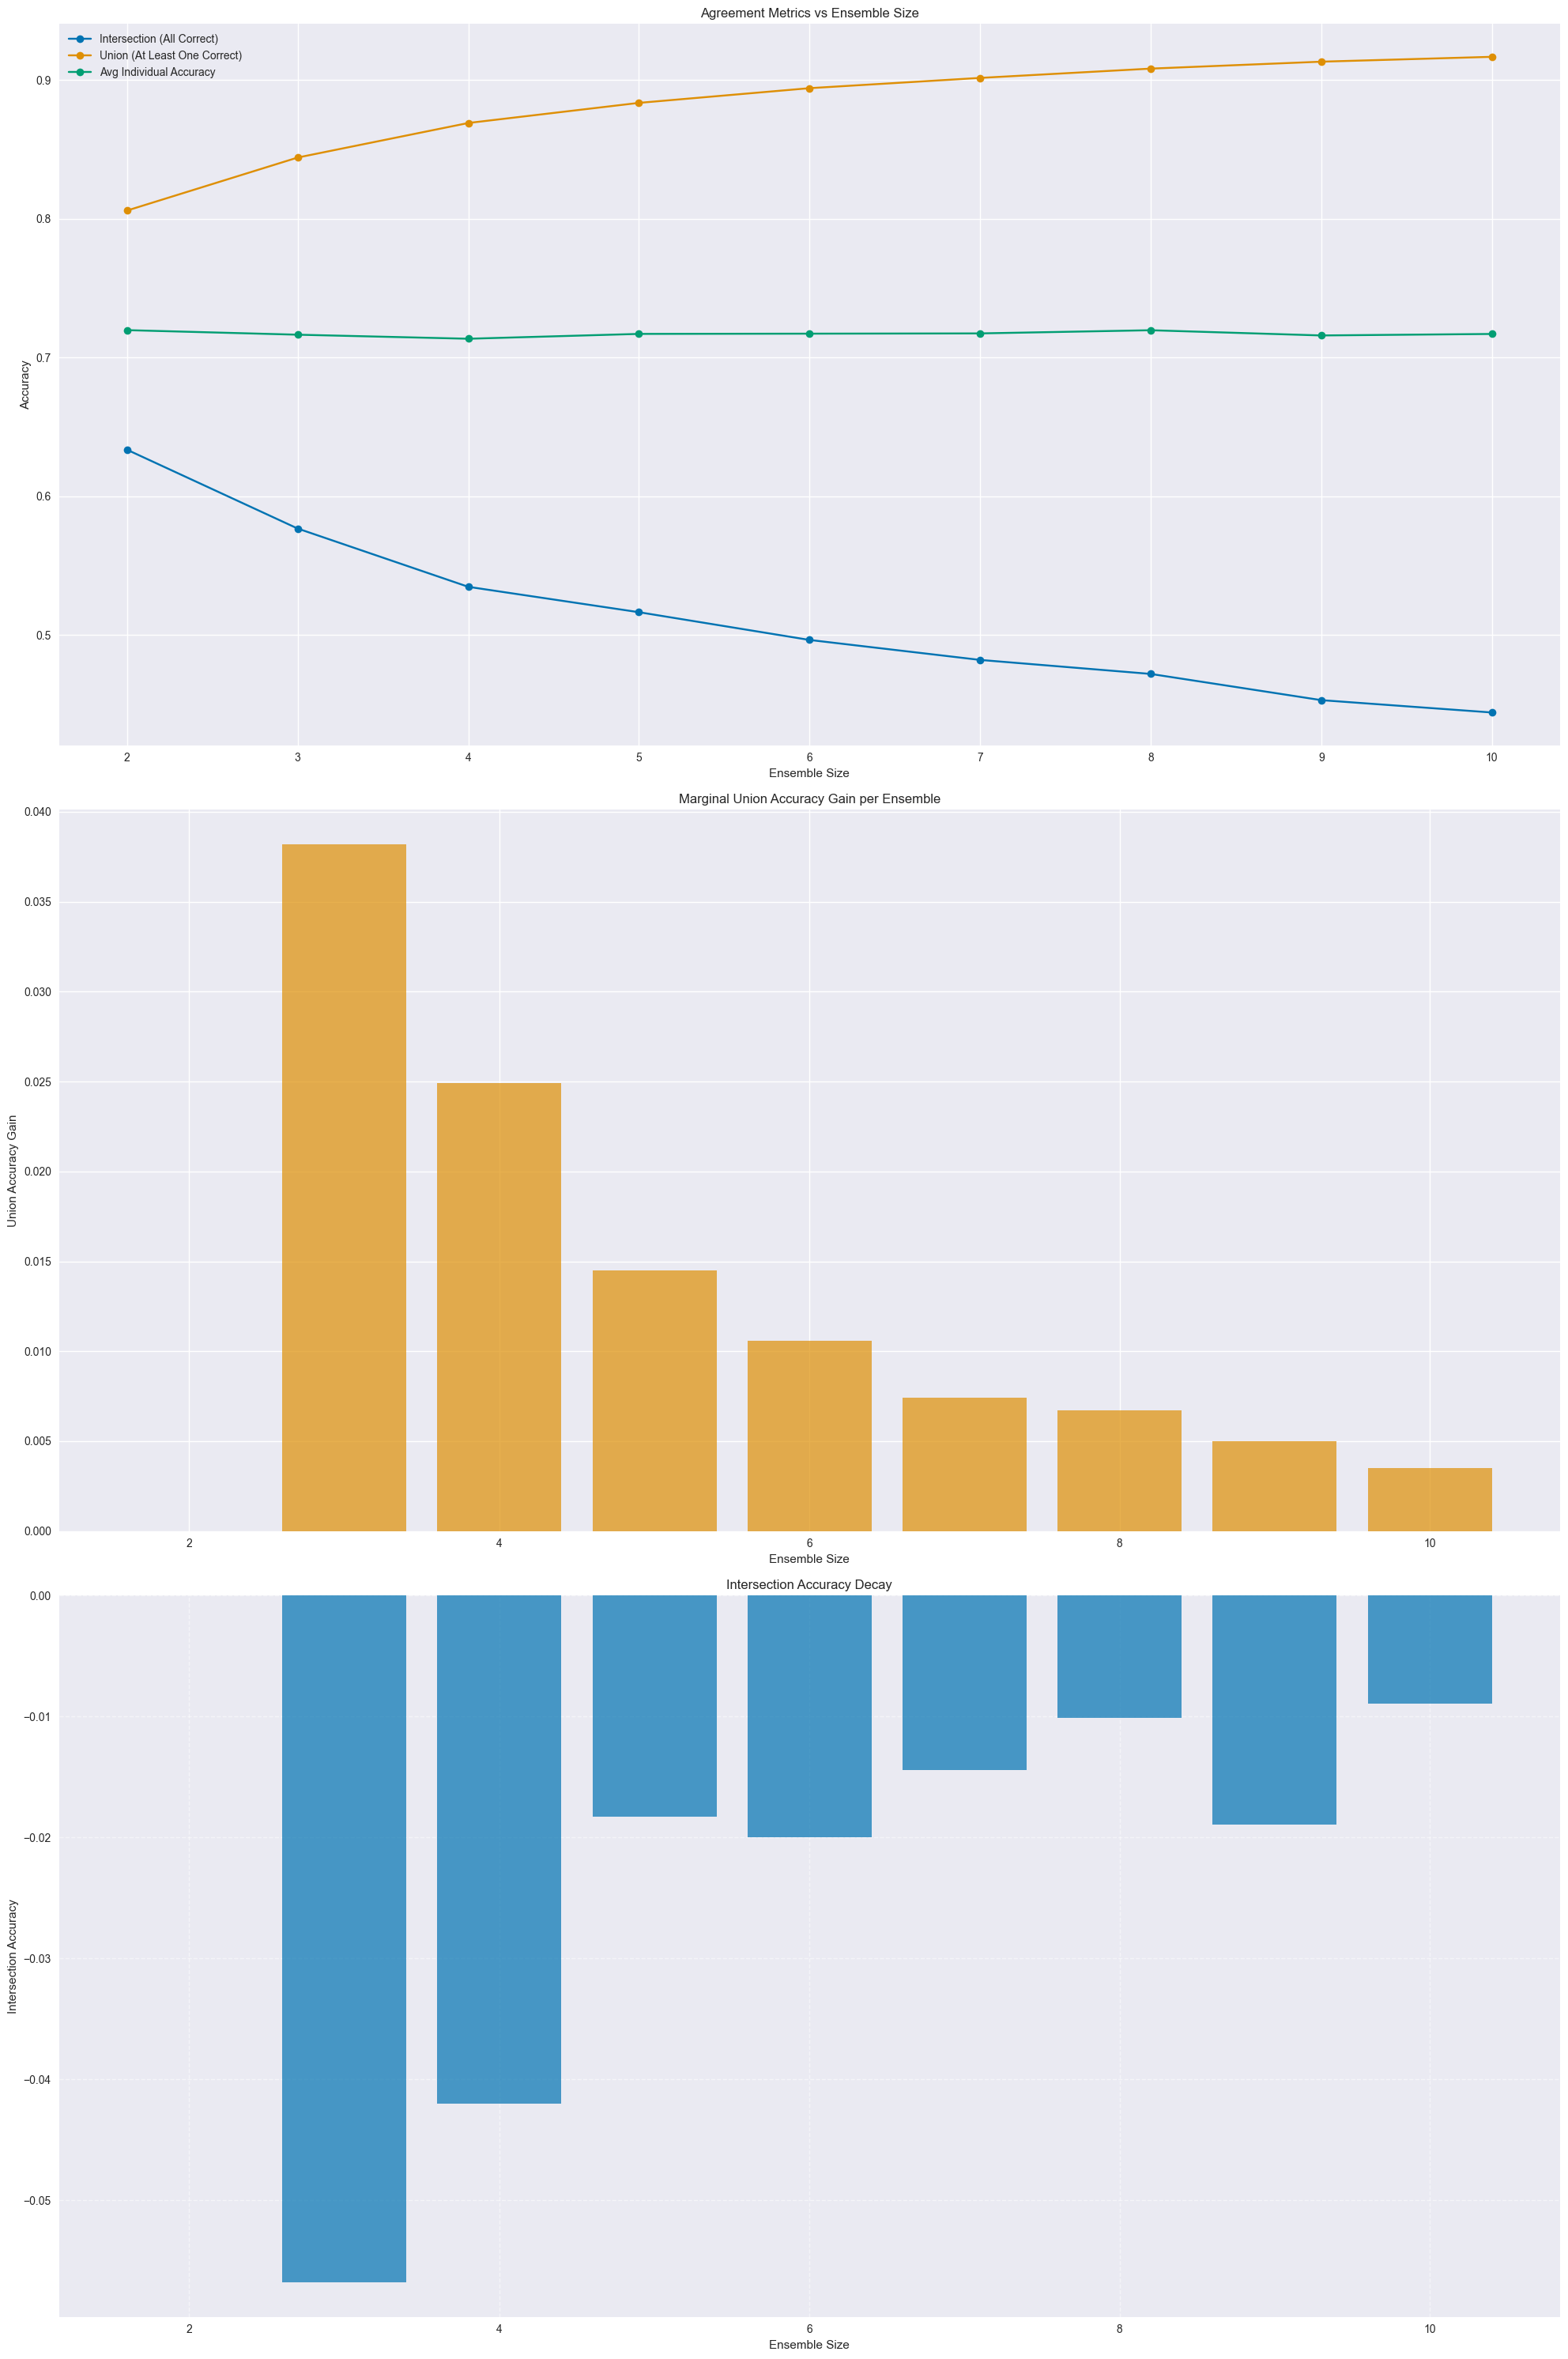

Intersection accuracy drops rapidly: from 0.633 (size=2) to 0.444 (size=10).
Union accuracy starts at 0.806 and plateaus at 0.917.
Union accuracy gain per model drops below 0.1% at ensemble size 7.
Average individual accuracy across ensembles: 0.717.


In [93]:
def multi_model_agreement_analysis(models, data_loader, random_seed=33):
    """
    Study agreement patterns across j=2,3,...,10 models.

    Key Analysis:
    1. Randomly order the 10 models using fixed seed for reproducibility
    2. For j in [2, 3, 4, ..., 10]:
       - Take first j models from random ordering
       - Compute intersection accuracy: % where ALL j models are correct
       - Compute union accuracy: % where AT LEAST ONE model is correct
    3. Track how these metrics evolve with ensemble size

    Args:
        models: List of 10 trained models from Part 1
        data_loader: Validation or test data loader  
        random_seed: Seed for reproducible model ordering

    Returns:
        ensemble_stats: Dictionary containing:
            - ensemble_sizes: [2, 3, 4, ..., 10]
            - intersection_accuracies: % where ALL models correct
            - union_accuracies: % where AT LEAST ONE model correct
            - individual_accuracies: Average accuracy of models in each ensemble
            - model_ordering: The random ordering used
    """
    np.random.seed(random_seed)
    torch.manual_seed(random_seed)

    # TODO: Create random ordering of models
    model_indices = list(range(len(models)))
    np.random.shuffle(model_indices)

    ensemble_sizes = list(range(2, len(models) + 1))
    intersection_accuracies = []
    union_accuracies = []
    individual_avg_accuracies = []

    # TODO: For each ensemble size j
    for j in ensemble_sizes:
        # TODO: Take first j models from random ordering
        current_models = [models[model_indices[i]] for i in range(j)]

        # TODO: Get predictions from all j models
        all_predictions = []  # Shape: (j, num_samples)
        all_correct = []      # Shape: (j, num_samples) - binary correctness
        all_labels = None
        for model in current_models:
            model.eval()
            preds = []
            labels = []
            with torch.no_grad():
                for xb, yb in data_loader:
                    xb = xb.to(next(model.parameters()).device)
                    logits = model(xb)
                    preds.append(logits.argmax(dim=1))
                    labels.append(yb.to(xb.device))
            preds = torch.cat(preds)
            labels = torch.cat(labels)
            all_predictions.append(preds)
            if all_labels is None:
                all_labels = labels

        all_predictions = torch.stack(all_predictions)  # (j, num_samples)
        all_correct = (all_predictions == all_labels.unsqueeze(0))  # broadcasting - (j, num_samples)       

        # TODO: Calculate intersection accuracy (ALL models correct)
        intersection_correct = torch.all(all_correct, dim=0)
        intersection_accuracy = intersection_correct.float().mean().item()
        intersection_accuracies.append(intersection_accuracy)


        # TODO: Calculate union accuracy (AT LEAST ONE model correct)  
        union_correct = torch.any(all_correct, dim=0)
        union_accuracy = union_correct.float().mean().item()
        union_accuracies.append(union_accuracy)

        # TODO: Calculate average individual accuracy of current ensemble
        individual_avg = all_correct.float().mean().item()
        individual_avg_accuracies.append(individual_avg)

    return {
        'ensemble_sizes': ensemble_sizes,
        'intersection_accuracies': intersection_accuracies,
        'union_accuracies': union_accuracies,
        'individual_avg_accuracies': individual_avg_accuracies,
        'model_ordering': model_indices
    }

def analyze_ensemble_patterns(ensemble_stats):
    """
    Analyze patterns in the ensemble agreement evolution.

    Key Insights to Discover:
    1. Intersection Decay: How quickly does "all correct" percentage drop?
    2. Union Saturation: Does "at least one correct" plateau?
    3. Diminishing Returns: When do additional models stop helping?
    4. Surprise Findings: Counter-intuitive patterns in the data

    Key Questions to Explore:
    - How rapidly does intersection accuracy decline with ensemble size?
    - Does union accuracy plateau, and if so, at what ensemble size?
    - What patterns emerge in the relationship between these metrics?
    """
    # TODO: Identify plateau points
    # TODO: Find optimal ensemble size for different objectives
    # TODO: Generate insights about diminishing returns
    intersection = np.array(ensemble_stats['intersection_accuracies'])
    union = np.array(ensemble_stats['union_accuracies'])
    individual = np.array(ensemble_stats['individual_avg_accuracies'])
    sizes = np.array(ensemble_stats['ensemble_sizes'])

    # TODO: Calculate rates of change
    intersection_drop = np.diff(intersection, prepend=intersection[0])
    union_gains = np.diff(union, prepend=union[0])

    # Union plateau: when marginal gain drops below 0.01
    mask = (union_gains < 0.01) & (union_gains > 0.00)
    union_plateau_idx = np.argmax(mask)
    if union_gains[union_plateau_idx] >= 0.01:
        union_plateau_idx = None

    # Diminishing returns: same as union plateau
    diminishing_returns_idx = union_plateau_idx

    # Summary
    summary = []
    summary.append(f"Intersection accuracy drops rapidly: from {intersection[0]:.3f} (size={sizes[0]}) to {intersection[-1]:.3f} (size={sizes[-1]}).")
    summary.append(f"Union accuracy starts at {union[0]:.3f} and plateaus at {union[-1]:.3f}.")
    if union_plateau_idx is not None:
        summary.append(f"Union accuracy gain per model drops below 0.1% at ensemble size {sizes[union_plateau_idx]}.")
    summary.append(f"Average individual accuracy across ensembles: {individual.mean():.3f}.")

    return {
        'intersection_drop': intersection_drop,
        'union_gains': union_gains,
        'union_plateau_idx': union_plateau_idx,
        'diminishing_returns_idx': diminishing_returns_idx,
        'summary': "\n".join(summary)
    }

def plot_ensemble_evolution(ensemble_stats):
    """Visualize how agreement evolves with ensemble size"""
    fig, axes = plt.subplots(3, 1, figsize=(20, 30))
    
    sizes = np.array(ensemble_stats['ensemble_sizes'])
    intersection = np.array(ensemble_stats['intersection_accuracies'])
    union = np.array(ensemble_stats['union_accuracies'])
    individual = np.array(ensemble_stats['individual_avg_accuracies'])


    # TODO: Plot 1 - Evolution of all three metrics
    ax = axes[0]
    ax.plot(sizes, intersection, marker='o', label='Intersection (All Correct)')
    ax.plot(sizes, union, marker='o', label='Union (At Least One Correct)')
    ax.plot(sizes, individual, marker='o', label='Avg Individual Accuracy')
    ax.set_xlabel('Ensemble Size')
    ax.set_ylabel('Accuracy')
    ax.set_title('Agreement Metrics vs Ensemble Size')
    ax.legend()
    ax.grid(True)

    ensembleRoC = analyze_ensemble_patterns(ensemble_stats)
    # TODO: Plot 2 - Marginal improvement analysis
    ax = axes[1]
    ax.bar(sizes, ensembleRoC['union_gains'], color='C1', alpha=0.7)
    ax.set_xlabel('Ensemble Size')
    ax.set_ylabel('Union Accuracy Gain')
    ax.set_title('Marginal Union Accuracy Gain per Ensemble')
    ax.grid(True)

    # TODO: Plot 3 - Intersection decay focus
    ax = axes[2]
    ax.bar(sizes, ensembleRoC['intersection_drop'], color='C0', alpha=0.7)
    ax.set_xlabel('Ensemble Size')
    ax.set_ylabel('Intersection Accuracy')
    ax.set_title('Intersection Accuracy Decay')
    ax.grid(True, which='both', ls='--', alpha=0.5)
    
    plt.tight_layout()
    plt.show()


ensembleStats = multi_model_agreement_analysis(trainer.models, testLoader)
plot_ensemble_evolution(ensembleStats)
ensembleAnalysis = analyze_ensemble_patterns(ensembleStats)
print(ensembleAnalysis['summary'])
